# EXPORT SHARES: UKRAINIAN AGRICULTURAL EXPORTS

Name: Josemaria Macedo Carrillo\
Created: 08/07/23\
Last modified: 09/07/23\
DSI

The purpose of this notebook is to analyze data on Ukrainian agricultural
exports for October 2022 (busiest month according to BSGI). The main data sources
are the Black Sea Grain Initiative (BSGI) of the United
Nations and Import Genius (IG), a website that has trade data for different countries
including Ukraine.

In [1]:
import sys
sys.path.append('..')
import pandas as pd
from utils.get_data import get_data, import_data
from utils.record_linkage import rl_ig_bsgi
from utils.plot import cargo_grouping, plot_line, plot_crops, plot_pie, plot_stack_bar
from utils.clean_data import PRODUCTS_VAL, translate_column, rename_columns, create_columns, clean_column
from utils.transform_data import estimate_weights, standard_company_name, create_wide_table
# from utils.record_linkage import record_linkage, unique_matches, filter_crop, find_matches
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator
import numpy as np
from utils.map import top_subsidiaries, top_parent, filter_country
import re
import copy
import os

## HELPER FUNCTIONS

In [4]:
#TODO: add this to a JSON and import

KNOW_COMPANIES = {"Kernel Holding S.A.": ["ДРУЖБА НОВА", "ЕНСЕЛКО АГРО", "ПОДІЛЛЯ АГРОСЕРВІС", "КЕРНЕЛ", "Kernel", "ТОВ ДРУЖБА 41300 СУМСЬКА ОБЛ М КРОЛЕВЕЦЬ ВУЛ КООПЕРАТИВНА БУД 3 Б"],
                  "UkrLandFarming PLC": ["VALINOR", "ДАКОР", "УКРЛЕНДФАРМІНГ", "ЮГТРАНЗИТСЕРВИС-АГРОПРОДУКТ", "АГРОКОМПАНІЯ ПРИКАРПАТТЯ", "UkrLandFarming"],
                  "MHP S.E.": ["МХП", "ТОВ КАТЕРИНОПІЛЬСЬКИЙ ЕЛЕВАТОР 20505 ЧЕРКАСЬКА ОБЛ ЗВЕНІГОРОДСЬКИЙ Р Н СМТ ЄРКИ ВУЛ ГЕРОЇВ МАЙ", "MHP", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ КАТЕРИНОПІЛЬСЬКИЙ ЕЛЕВАТОР 20505 ЧЕРКАСЬКА ОБЛ ЗВЕНИГОРОДСЬКИЙ Р Н СЕЛИЩЕ МІСЬКОГО ТИПУ ЄРКИ", "ТОВ КАТЕРИНОПІЛЬСЬКИЙ ЕЛЕВАТОР 20505 ЧЕРКАСЬКА ОБЛ ЗВЕНИГОРОДСЬКИЙ Р Н СМТ ЄРКИ ВУЛ ГЕРОЇВ МАЙД"],
                  "TNA Corporate Solutions LLC": ["ПІВДЕНЬ АГРО ІНВЕСТ", "ПТАХОФАБРИКА ПОДІЛЛЯ", "ПРИДНІПРОВСЬКА", "РАЙЗ-МАКСИМКО", "ПРИДНІПРОВСЬКЕ", "TNA", "ТОВ ПОДІЛЛЯ АГРОПРОДУКТ 23130 ВІННИЦЬКА ОБЛ ЖМЕРИНСЬКИЙ Р Н СМТ БРАЇЛІВ ВУЛ ЗАВОДСЬКА Б"],
                  "NCH Capital Inc.": ["АГРОПРОСПЕРІС", "НХЦ", "NCH"],
                  "Astarta Holding": ["АСТАРТА", "ДОБРОБУТ", "ПОЛТАВАЗЕРНОПРОДУКТ", "ХМІЛЬНИЦЬКЕ", "АГРО КА", "Astarta", "Agrofirm named after Dovzhenko", "ТОВ АГРОФІРМА ІМ ДОВЖЕНКА 38030 ПОЛТАВСЬКА ОБЛ МИРГОРОДСЬКИЙ Р Н С ЯРЕСЬКИ ВУЛ КОЗАЦЬКИЙ ШЛ", "Volochysk-Agro", "ТОВ ВОЛОЧИСЬК АГРО"],
                  "Industrial Milk Company (IMC) S.A.": ["АГРОПРОГРЕС", "СЛОБОЖАНЩИНА АГРО", "АГРОКІМ", "БУРАТ АГРО", "ЛОСИНІВКА АГРО", "ИМЦ", "IMC"],
                  "Public Investment Fund (PIF) of Saudi Arabia": ["SALIC", "АГРО ЛВ", "МРІЯ ФАРМІНГ", "PIF", "ПИФ", "ТОВ СІЕФДЖІ ТРЕЙДИНГ УКРАЇНА 47602 ТЕРНОПІЛЬСЬКА ОБЛ ТЕРНОПІЛЬСЬКИЙ Р Н СМТ КОЗОВА ВУ", "Continental Farmers Group", "ТОВ СІЕФДЖІ ТРЕЙДИНГ"],
                  "Agroton Public Limited": ["АГРОТОН", "Agroton"],
                  "Nibulon": ["НІБУЛОН", "Nibulon"],
                  "System Capital Management (SCM)": ["АГРО ХОЛДИНГ МС", "System Capital Management", "SCM", "СЦМ"],
                  "Louis Dreyfus": ["Louis Dreyfus", "ТОВ ЛУЇ ДРЕЙФУС КОМПАНІ УКРАЇНА 01001 М КИЇВ ПЛОЩА СПОРТИВНА БЦ ГУЛІВЕР БУД 1 А ПОВЕРХ 15", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ЛУЇ ДРЕЙФУС КОМПАНІ УКРАЇНА 01001 М КИЇВ ПЛОЩА СПОРТИВНА БЦ ГУЛІВЕР БУДИНОК 1 А ПОВЕРХ 15"],
                  "Cargill": ["Cargill", "ТОВ АТ КАРГІЛЛ 03150 УКРАЇНА М КИЇВ ВУЛИЦЯ ВЕЛИКА ВАСИЛЬКІВСЬКА БУД 139", "ТОВ АТ КАРГІЛЛ 03150 УКРАЇНА М КИЇВ ВУЛ ВЕЛИКА ВАСИЛЬКІВСЬКА БУД 139", "ТОВ АТ КАРГІЛЛ 03150 М КИЇВ ВУЛ ВЕЛИКА ВАСИЛЬКІВСЬКА БУД 139"],
                  "Glencore": ["Glencore"],
                  "Marubeni": ["Marubeni"],
                  "Bunge": ["Bunge", "Suntrade", "САНТРЕЙД"],
                  "Noble Resources": ["Noble Resources"],
                  "Viterra Ukraine": ["Viterra", "ПІДПРИЄМСТВО З ІНОЗЕМНИМИ ІНВЕСТИЦІЯМИ ВАЙТЕРРА УКРАЇНА", "ПІІ ВАЙТЕРРА УКРАЇНА"],
                  "Ardeon Tsentr": ["Ardeon", "ТОВ АРДЕОН ЦЕНТР 07301 КИЇВСЬКА ОБЛ М ВИШГОРОД ВУЛ ВАТУТІНА БУД 69 Г ОФІС 2/4"],
                  "Allseeds Group": ["Allseeds", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ОЛСІДЗ ГРУП УКРАЇНА 04655 М КИЇВ ВУЛ ВЕРХНІЙ ВАЛ БУД 72"],
                  "Delta Wilmar Ukraine": ["Delta Wilmar Ukraine", "ТОВ ДЕЛЬТА ВІЛМАР УКРАЇНА 65481 ОДЕСЬКА ОБЛ МІСТО ЮЖНЕ ВУЛИЦЯ ІНДУСТРІАЛЬНА БУДИНОК 6"],
                  "Bioenergy-Vinnytsia": ["Bioenergy-Vinnytsia", "ТОВ БІОЕНЕРДЖІ ВІННИЦЯ 23130 ВІННИЦЬКА ОБЛ ЖМЕРИНСЬКИЙ Р Н СМТ БРАЇЛІВ ВУЛ ЗАВОДСЬКА БУ"],
                  "SFGCU": ["State Food and Grain Corporation of Ukraine", "АКЦІОНЕРНЕ ТОВАРИСТВО ДЕРЖАВНА ПРОДОВОЛЬЧО ЗЕРНОВА КОРПОРАЦІЯ УКРАЇНИ 01033 М КИЇВ ВУЛ САКСАГАНСЬКОГО 1", "SFGCU"],
                  "Karla Marksa 2": ["Karla Marksa", "ПП КАРЛА МАРКСА 2 41543 СУМСЬКА ОБЛ КОНОТОПСЬКИЙ РАЙОН С МІНАКОВЕ ВУЛ САДОВА БУД 6"],
                  "Optimus Agro": ["Optimus Agro", "ТОВ ОПТІМУСАГРО ТРЕЙД 49033 ДНІПРОПЕТРОВСЬКА ОБЛ М ДНІПРО ПР Т БОГДАНА ХМЕЛЬНИЦЬКОГО Б", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ОПТІМУСАГРО ТРЕЙД 69014 ЗАПОРІЗЬКА ОБЛ МІСТО ЗАПОРІЖЖЯ ВУЛ ХАРЧОВА БУДИНОК 3"],
                  "Archer Daniels Midland": ["ADM Ukraine", "Archer Daniels Midland", "ТОВ АДМ ЮКРЕЙН 04070 М КИЇВ ВУЛ ПЕТРА САГАЙДАЧНОГО БУД 16 А УКРАЇНА", "ТОВ АДМ ЮКРЕЙН УКРАЇНА 04070 М КИЇВ ПОДІЛЬСЬКИЙ Р Н ВУЛ ПЕТРА САГАЙДАЧНОГО БУД 16 А"],
                  "Ossoyo": ["Ossoyo", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ОССОЙО УКРАЇНА 01054 МІСТО КИЇВ ВУЛ ГОНЧАРА ОЛЕСЯ БУДИНОК 35 ПРИМІЩЕННЯ", "ОССОЙО"],
                  "D.Trading": ["D.Trading", "ТОВ Д ТРЕЙДІНГ 04119 М КИЇВ ВУЛИЦЯ ХОХЛОВИХ СІМ Ї БУДИНОК 8 ЛІТЕРА 20Д"],
                  "HS Airlines": ["HS Airlines", "ТОВ ЕЙЧ ЕС ЕЙРЛАЙНС 65039 ОДЕСЬКА ОБЛ М ОДЕСА ВУЛ ТРАНСПОРТНА БУД 5/1"],
                  "Willers": ["Willers", "ТОВ ВІЛЕРС 04053 М КИЇВ ВОЗНЕСЕНСЬКИЙ УЗВІЗ БУД 14 ОФ 16/7"],
                  "Nimeri Hold": ["Nimeri Hold", "ТОВ НІМЕРІ ГОЛД 65048 ОДЕСЬКА ОБЛ М ОДЕСА ВУЛ КАНАТНА БУД 42 ОФ 975"],
                  "Smartsystems": ["Smartsystems", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ СМАРТСИСТЕМС 54003 МИКОЛАЇВСЬКА ОБЛ М МИКОЛАЇВ ПР ЦЕНТРАЛЬНИЙ БУДИНОК 269/3"],
                  "New Logist Ukraine": ["New Logist Ukraine", "ТОВ НЬЮ ЛОГІСТ ЮКРЕЙН 65005 М ОДЕСА ВУЛ БАЛКІВСЬКА БУД 108 КАБ 27", "ТОВ НЬЮ ЛОГІСТ ЮКРЕЙН 65005 УКРАЇНА М ОДЕСА ВУЛ БАЛКІВСЬКА 108 КАБ 27", "ТОВ НЬЮ ЛОГІСТ ЮКРЕЙН 65005 УКРАЇНА М ОДЕСА ВУЛ БАЛКІВСЬКА 108 КАБ 27", "ТОВ НЬЮ ЛОГІСТ ЮКРЕЙН УКРАЇНА 65005 М ОДЕСА ВУЛ БАЛКІВСЬКА БУД 108 КАБ 27"],
                  "Trade Westend": ["Trade Westend", "ТОВ ТРЕЙД ВЕСТЕНД 79007 М ЛЬВІВ ВУЛ ШПИТАЛЬНА БУД 9 УКРАЇНА", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ТРЕЙД ВЕСТЕНД 79007 ЛЬВІВСЬКА ОБЛ МІСТО ЛЬВІВ ВУЛ ШПИТАЛЬНА БУДИНОК 9"],
                  "Verkhivtsevsky Oil Extraction Plant 'Soloma'": ["Verkhivtsevsky Oil Extraction Plant", "Soloma", "ТОВ СОЛОМА 51660 ДНІПРОПЕТРОВСЬКА ОБЛ ВЕРХНЬОДНІПРОВСЬКИЙ Р ОН М ВЕРХІВЦЕВЕ"],
                  "Korsun-Shevchenkivsky Grain Reception Enterprise": ["Korsun-Shevchenkivsky Grain Reception Enterprise", "ТОВ КОРСУНЬ ШЕВЧЕНКІВСЬКЕ ХЛІБОПРИЙМАЛЬНЕ ПІДПРИЄМСТВО 19402 ЧЕРКАСЬКА ОБЛ М КОРСУНЬ ШЕВЧ ЕНКІВСЬКИЙ ПРОВ ПРОМИСЛОВИЙ БУД 6"],
                  "Tolans": ["Tolans", "ТОВ СТИВІДОРНА КОМПАНІЯ ОКТЯБРЬСКА УКРАЇНА 57214 МИКОЛАЇВСЬКА ОБЛ ВІТОВСЬКИЙ Р Н СЕЛО МІШКОВО ПОГОРІ", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ СТИВІДОРНА КОМПАНІЯ ОКТЯБРЬСК 57214 МИКОЛАЇВСЬКА ОБЛАСТЬ ВІТОВСЬКИЙ РАЙОН СЕЛО МІШКОВО ПОГОРІЛОВЕ"],
                  "TH Novaagro": ["TH Novaagro", "ТОВ ТБ НОВААГРО 61002 М ХАРКІВ ВУЛ ЧЕРНИШЕВСЬКА БУД 66"],
                  "Analytictrade": ["Analytictrade", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ АНАЛІТИКТРЕЙД 54001 МИКОЛАЇВСЬКА ОБЛ МІСТО МИКОЛАЇВ ВУЛ ШЕВЧЕНКА БУД 71 ОФІС"],
                  "New Agro Podillya LLC": ["New Agro Podillya", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ НЬЮ АГРО ПОДІЛЛЯ 32207 ХМЕЛЬНИЦЬКА ОБЛ ХМЕЛЬНИЦЬКИЙ РН С ЯБЛУНІВКА ПРОВ МИРУ БУД 1"],
                  "Group of companies Vitagro LLC": ["Vitagro", "ПП АГРАРНА КОМПАНІЯ 2004 31222 УКРАЇНА ХМЕЛЬНИЦЬКА ОБЛ ВОЛОЧИСЬКИЙ Р Н С ПОПІВЦІ ВУЛ ШК"],
                  "Eridon PE": ["Eridon", "ТОВ ФІРМА ЕРІДОН 08467 КИЇВСЬКА ОБЛ ПЕРЕЯСЛАВ ХМЕЛЬНИЦЬКИЙ Р Н С ЧОПИЛКИ ВУЛ БОГДА"],
                  "Vesele-Agro LLC": ["Vesele-Agro", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ВЕСЕЛЕ АГРО УКРАЇНА 45611 ВОЛИНСЬКА ОБЛ ЛУЦЬКИЙ Р Н СЕЛО ВЕСЕЛЕ ВУЛ ТОРЧИНС"],
                  "Kurland": ["Kurland", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ КУРЛАНД УКРАЇНА 23152 ВІННИЦЬКА ОБЛ ЖМЕРИНСЬКИЙ Р Н С ТЕЛЕЛИНЦІ ВУЛ ЦЕН"],
                  "Vorozhbalatinvest LLC": ["Vorozhbalatinvest", "ТОВ ВОРОЖБАЛАТІНВЕСТ 42240 СУМСЬКА ОБЛ ЛЕБЕДИНСЬКИЙ РАЙОН С ВОРОЖБА ВУЛ СУМСЬКА БУД 1"],
                  "MIR 12": ["MIR 12", "ТОВ МИР 12 41532 СУМСЬКА ОБЛ КОНОТОПСЬКИЙ Р Н С МАЗІВКА ВУЛ МИРУ БУД 14"],
                  "Promin Podillya LLC": ["Promin Podillya", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ПРОМІНЬ ПОДІЛЛЯ УКРАЇНА 32625 ХМЕЛЬНИЦЬКА ОБЛ НОВОУШИЦЬКИЙ Р Н СЕЛО ПЕСЕЦЬ ВУЛ"],
                  "Olyshchivka": ["Olyshchivka", "ТОВ ОЛИШІВКА 15575 ЧЕРНІГІВСЬКА ОБЛ ЧЕРНІГІВСЬК Р Н СМТ ОЛИШІВКА В ЧЕРНІГІВСЬКА Б"],
                  "Ukrainian Agricultural Enterprise": ["Ukrainian Agricultural Enterprise", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ СІЛЬСЬКОГОСПОДАРСЬКЕ ПІДПРИЄМС 54002 УКРАЇНА М МИКОЛАЇВ ВУЛ КАБОТАЖНИЙ СПУСК 1"],
                  "Fin-Invest Polissia": ["Fin-Invest Polissia", "ТОВ ФІН ІНВЕСТ ПОЛІССЯ"],
                  "Krauka": ["Krauka", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ КРАУКА 65031 ОДЕСЬКА ОБЛ МІСТО ОДЕСА ВУЛ ХІМІЧНА БУДИНОК 1/2", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ КРАУКА УКРАЇНА 65031 ОДЕСЬКА ОБЛ МІСТО ОДЕСА ВУЛ ХІМІЧНА БУДИНОК 1/2"],
                  "Systemy Transportnykh Pokryttiv": ["Systemy Transportnykh Pokryttiv", "ТОВ СИСТЕМИ ТРАНСПОРТНИХ ПОКРИТТІВ УКРАЇНА 68000 ОДЕСЬКА ОБЛ М ЧОРНОМОРСЬК ВУЛ ТРАНСПОРТНА БУД 9"],
                  "Trepfin": ["Trepfin", "ТОВ ТРЕПФІН 03150 М КИЇВ ВУЛ ПРЕДСЛАВИНСЬКА БУД 34 Б"],
                  "Likhachevsky Elevator": ["Likhachevsky Elevator", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ЛИХАЧОВСЬКИЙ ЕЛЕВАТОР 64107 ХАРКІВСЬКА ОБЛ ЛОЗІВСЬКИЙ Р Н МІСТО ПЕРВОМАЙСЬКИЙ ПРОВ ЛІС"],
                  "COFCO": ["Cofco", "ТОВ КОФКО АГРІ РЕСОРСІЗ УКРАЇНА 01133 М КИЇВ ВУЛ ЄВГЕНА КОНОВАЛЬЦЯ БУД 32 Б ОФІС 1019 УКРАЇНА"],
                  "Holdfins Layt": ["Holdfins Layt", "ТОВ ГОЛДФІНС ЛАЙТ 03187 УКРАЇНА М КИЇВ ВУЛ ЗАБОЛОТНОГО АКАДЕМІКА БУД 48А"],
                  "Olam": ["Olam", "ТОВ ОЛАМ УКРАЇНА"],
                  "LNZ Group S.A.": ["LNZ Group", "Lebedyn Seed Plant", "ПРАТ ЛЕБЕДИНСЬКИЙ НАСІННЄВИЙ ЗАВОД"],
                  "Zlata-Trade": ["Zlata-Trade", "ТОВ ЗЛАТА ТРЕЙД УКРАЇНА", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ЗЛАТА ТРЕЙД УКРАЇНА 68200 ОДЕСЬКА ОБЛ САРАТСЬКИЙ Р Н СЕЛИЩЕ МИСЬКОГО ТИПУ САР"],
                  "Nika Trade": ["Nika Trade", "ТОВ НІКА ТРЕЙД ДНІПРО УКРАЇНА"],
                  "Limbo Pro": ["Limbo Pro", "ТОВ ЛІМБО ПРО"],
                  "Niva Pereyaslavshchyny": ["Niva Pereyaslavshchyny", "СП ТОВ НИВА ПЕРЕЯСЛАВЩИНИ УКРАЇНА"],
                  "Raykomiia": ["Raykomiia", "ТОВ РАЙКОМІЯ", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ РАЙКОМІЯ 65031 ОДЕСЬКА ОБЛ МІСТО ОДЕСА ВУЛ ХІМІЧНА БУДИНОК 1/2"],
                  "Taraban": ["Taraban", "ТОВ ТАРАБАН", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ <ТАРАБАН> 65031 ОДЕСЬКА ОБЛ МІСТО ОДЕСА ВУЛ ХІМІЧНА БУДИНОК 1/2"],
                  "Vilker": ["Vilker", "ТОВ ВІЛКЕР"],
                  "Transit Agro-M": ["Transit Agro-M", "ТОВ ТРАНЗИТ АГРО М УКРАЇНА", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ТРАНЗИТ АГРО М УКРАЇНА 04119 МІСТО КИЇВ ВУЛ ХОХЛОВИХ СІМ Ї БУДИНОК 8"],
                  "Lintardo": ["Lintardo", "ТОВ АГРОСВІТ КОЛО"],
                  "Agrofirma Rokytne": ["Agrofirma Rokytne", "ТОВ АГРОФІРМА РОКИТНЕ УКРАЇНА"],
                  "Elevator Agro": ["Elevator Agro", "ТОВ ЕЛЕВАТОР АГРО УКРАЇНА", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ЕЛЕВАТОР АГРО УКРАЇНА 37240 ПОЛТАВСЬКА ОБЛ МИРГОРОДСЬКИЙ Р Н М ЗАВОДСЬКЕ ВУЛ"],
                  "Vilter": ["Vilter", "ТОВ ВІЛТЕР"],
                  "Neko Oilz": ["Neko Oilz", "ТОВ НЕКО ОІЛЗ УКРАЇНА"],
                  "Venom Grain": ["Venom Grain", "ТОВ ВЕНОМ ГРЕЙН"],
                  "Tavamis Hrup": ["Tavamis", "ТОВ ТАВАМІС"],
                  "Agrofirm Svitanok": ["Agrofirm Svitanok", "ПСП АГРОФІРМА СВІТАНОК"],
                  "Chysta Krynytsia": ["Chysta Krynytsia", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ЧИСТА КРИНИЦЯ 39351 ПОЛТАВСЬКА ОБЛ НОВОСАНЖАРСЬКИЙ РН С ДРАБИНІВКА ВУЛ ЦЕНТРАЛЬНА Б"],
                  "Sanlex Invest": ["Sanlex Invest", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ САНЛЕКС ІНВЕСТ УКРАЇНА 03150 МІСТО КИЇВ ВУЛ ДІЛОВА БУДИНОК 2Б ОФІС 107"],
                  "Amedia Group": ["Amedia Group", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ТД АМЕДІА ТОРГ УКРАЇНА 02121 М КИЇВ ПР БАЖАНА МИКОЛИ 3"],
                  "Private Agricultural Enterprise Ukraine": ["Private Agricultural Enterprise Ukraine", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ СІЛЬСЬКОГОСПОДАРСЬКЕ ПІДПРИЄМ УКРАЇНА 31362 ХМЕЛЬНИЦЬКА ОБЛ ХМЕЛЬНИЦЬКИЙ Р Н СЕЛО РОЗСОША"],
                  "Renter Group": ["Renter Group", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ <РЕНТЕР ГРУП> УКРАЇНА 04060 МІСТО КИЇВ ВУЛ БЕРЛІНСЬКОГО МАКСИМА БУД 9", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ РЕНТЕР ГРУП УКРАЇНА 04060 МІСТО КИЇВ ВУЛ БЕРЛІНСЬКОГО МАКСИМА БУД 9"],
                  "Epicentr-K LLC": ["Epicentr K", "ТОВ ЕПІЦЕНТР К УКРАЇНА 04128 МІСТО КИЇВ ВУЛ БЕРКОВЕЦЬКА БУД 6 К"],
                  "Interflot": ["Interflot", "ТОВ ІНТЕРФЛОТ УКРАЇНА 03142 М КИЇВ ПР Т АКАДЕМІКА ПАЛЛАДІНА 44 КОРПУС 8"],
                  "Senteotl": ["Senteotl", "ТОВ СЕНТЕОТЛЬ 65065 ОДЕСЬКА ОБЛ М ОДЕСА ВУЛ ІНГЛЕЗІ БУД 8"],
                  "Groot Trade": ["Groot Trade", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ ГРУТ ТРЕЙД УКРАЇНА 61157 ХАРКІВСЬКА ОБЛ М ХАРКІВ ВУЛ МОСКАЛІВСЬКА БУД 99"],
                  "Agrotech-Garantia": ["Agrotech-Garantia", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ АГРОТЕХ ГАРАНТІЯ", "ТОВ АГРОТЕХ ГАРАНТІЯ"],
                  "Zerno Agro": ["Zerno Agro", "ТОВ ЗЕРНО АГРО 65016 ОДЕСЬКА ОБЛ М ОДЕСА ВУЛ ЛІТЕРАТУРНА БУД 8 ОФІС 6"],
                  "Askano": ["Askano", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ АСКАНО УКРАЇНА 65000 ОДЕСЬКА ОБЛ М ОДЕСА ВУЛ ПАНТЕЛЕЙМОНІВСЬКА БУД 25", "ТОВ АСКАНО"],
                  "Altpro": ["Altpro", "ТОВ АЛЬТПРО УКРАЇНА 65012 М ОДЕСА КУЛИКОВЕ ПОЛЕ БУДИНОК 1"],
                  "Vizmir Market": ["Vizmir Market", "ТОВ ВІЗМІР МАРКЕТ"],
                  "Paymont Active": ["Paymont Active", "ТОВ ПЕЙМОНТ АКТИВ"],
                  "Shekolan": ["Shekolan", "ТОВ ШЕКОЛАН"],
                  "Donlarni": ["Donlarni", "ТОВ ДОНЛАРНІ"],
                  "MP Nіko": ["MP Nіko", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ МП НІКО", "ТОВ МП НІКО"],
                  "Rise Pivnich": ["Rise Pivnich", "ТОВ РАЙЗ ПІВНІЧ УКРАЇНА 42304 СУМСЬКА ОБЛ СУМСЬКИЙ Р Н СМТ СТЕПАНІВКА ВУЛ ЗАВОД"],
                  "Hertsum": ["Hertsum", "ТОВ ГЕРЦУМ 65005 М ОДЕСА ВУЛ БАЛКІВСЬКА БУД 108 КАБ 27"],
                  "Inveks Group": ["Inveks Group", "ТОВ ІНВЕКС ГРУП 02132 М КИЇВ ПРОСПЕКТ БАЖАНА МИКОЛИ 151 ОФ 37"],
                  "Agro-region": ["Agro-region", "Garna Trading", "ТОВ ГАРНА ТРЕЙДИНГ"],
                  "Batkivshchyna": ["Batkivshchyna", "ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ БАТЬКІВЩ", "ТОВ БАТЬКІВЩ"],
                  "Tesslagroup": ["Tesslagroup", "ТОВ ТЕССЛАГРУП"],
                  "Company Farmco": ["Company Farmco", "ТОВ КОМПАНІЯ ФАРМКО"],
                  "Premium Eksport": ["Premium Eksport", "ТОВ ПРЕМІУМ ЕКСПОРТ"]}

ASIAN_COUNTRIES = {"india": "індія", "viet nam": "в єтнам",
                   "sri lanka": "шрі ланка"}

ASIA_NAME_DICT = {"в'єтнам": "в єтнам", "в єтнам": "в єтнам", "індія": "індія", "шрі-ланка": "шрі ланка", "шрі ланка": "шрі ланка"}

SPAIN_NAME_DICT = {"іспанія": "іспанія"}


def correct_name(series, name_dict):
    """
    Update column values from a dataframe with correct ones.

    Inputs:
        series (Series): column we want to update
        name_dict (dict): dictionary with incorrect names as keys and correct
            names as values.
    
    Returns: series with correct names.
    """
    return series.apply(lambda x: name_dict[x])

def filter_country(deals, country):
    """
    Filter land deals for a specific country

    Inputs:
        deals (DataFrame): dataframe with land deals data
        country (str): country name

    Returns (DataFrame): dataframe with country land locations
    """
    deals_c = deals.copy()
    deals_c.loc[:, "country_low"] = deals_c.loc[:, "Target country"].str.lower()
    deals_c = deals_c.loc[deals_c.loc[:, "country_low"].str.contains(country.lower(),
                                                                     na=False)]
    
    return deals_c

def extend_list(list, character):
    """
    Create new list with split text based on "character" parameter

    Inputs:
        list (lst): list of strings
        character (str): character to use to separate string values in list

    Returns (lst): new list with split text based on "character" parameter
    """
    new_lst = []
    for value in list:
        new_lst += value.split(character)

    return new_lst

def clean_list(list, pattern):
    """
    Create new list with clean text based on "pattern" parameter

    Inputs:
        list (lst): list of strings
        pattern (str): pattern we want to find and replace in each string value
            on the list

    Returns (lst): None. Makes changes in place in input "list".
    """
    for i, value in enumerate(list):
        match = re.search(pattern, value)
        if match:
            list[i] = match.group(0)

def parent_subsidiary_dict(parent_lst, deals_data, n_subsidiaries):
    """
    Create dictionary with parent companies as keys and subsidaries as values.

    Inputs:
        parent_lst (lst): list of parent companies
        deals_data (DataFrame): deals dataframe where we're going to look for
            subsidiaries
        n_subsidiaries (int): number of subsidiaries we want to get for parent
            company.

    Returns (dict): dictionary with parent companies as keys and subsidaries as
        values.
    """
    subsidiaries_dict = {}

    for parent in parent_lst:
        subsidiaries_dict[parent] = top_subsidiaries(deals_data, parent,
                                                     n_subsidiaries)

    return subsidiaries_dict

def translate_subsidiaries(dict, source_lan, target_lan):
    """
    Create dictionary with translated subsidiaries' names as values.

    Inputs:
        dict (dict): dictionary with subsidarie names in English
        source_lan (str): current language code of values of dictionary
        target_lan (str): target language code we want to translate values to


    Returns (dict): dictionary with parent companies as keys and subsidaries as
        values.
    """
    d_target = {}

    for parent, sub_lst in dict.items():
        target_lst = []
        for subsidiary in sub_lst:
            target_lst.append(GoogleTranslator(source_lan, target_lan).\
                              translate(subsidiary))
        d_target[parent] = target_lst

    return d_target

def manually_add_subsidiaries(original_dict, manual_dict):
    """
    Add subsidaries manually as values to company dictionary.

    Inputs:
        manual_dict (dict): dictionary with parent companies as keys and
            subsidaries as values.
        source_lan (str): current language code of values of dictionary
        target_lan (str): target language code we want to translate values to


    Returns (dict): dictionary with parent companies as keys and subsidaries as
        values.
    """
    for parent, subsidiary_lst in manual_dict.items():
        for i, subsidiary in enumerate(subsidiary_lst):
            subsidiary_lst[i] = subsidiary.lower()
        if parent in original_dict:
            original_dict[parent] += manual_dict[parent]
        else:
            original_dict[parent] = manual_dict[parent]

    return original_dict

def dict_to_lower(dict):
    """
    Convert dictionary values of 'dict' to lowercase

    Inputs:
        dict (dict): dictionary with parent companies as keys and subsidaries
            as values.

    Returns (dict): None. The function does the change in place of the input
        'dict'.
    """
    for parent, subsidiary_lst in dict.items():
        for i, subsidiary in enumerate(subsidiary_lst):
            subsidiary_lst[i] = subsidiary.lower()

def add_companies_manually(old_dict, new_dict):
    """
    Add non-repeated values from 'new_dict' to 'old_dict' based on keys.

    Inputs:
        old_dict (dict): dictionary with parent companies as keys and
            subsidaries as values.
        new_dict (dict): dictionary with parent companies as keys and new
            subsidaries as values.

    Returns (dict): dictionary with non-repeated values from 'new_dict' to
        'old_dict' based on keys.
    """
    old_dict_copy = copy.deepcopy(old_dict)
    
    for parent, subsidiary_lst in new_dict.items():
        for i, subsidiary in enumerate(subsidiary_lst):
            subsidiary_lst[i] = subsidiary.lower()

        if parent in old_dict_copy:
            # old_dict_copy[parent] += new_dict[parent]
            old_dict_copy[parent].extend(subsidiary_lst)
        else:
            # old_dict_copy[parent] = new_dict[parent]
            old_dict_copy[parent] = subsidiary_lst
    
    return old_dict_copy

def estimate_table_percentages(table):
    """
    Add non-repeated values from 'new_dict' to 'old_dict' based on keys.

    Inputs:
        old_dict (dict): dictionary with parent companies as keys and
            subsidaries as values.
        new_dict (dict): dictionary with parent companies as keys and new
            subsidaries as values.

    Returns (dict): None. The function does the change in place of the input
        'old_dict'.
    """
    table = table.fillna(0)
    date = table["date"]
    percentage_df = table.drop(columns=["date"]).divide(table.drop(columns=\
                                            ["date"]).sum(axis=1), axis=0) * 100
    percentage_df = percentage_df.round(2)
    percentage_df["date"] = date
    
    return percentage_df

def plot_multiple_countries(country_dict, data, y_axis_limit, source):
    """
    Plot stacked bar charts for more than one country

    Inputs:
        country_dict (dict): dictionary with country names in BSGI as keys
            (in English) and country names in IG as values (Ukrainian)
        data (DataFrame): dataset with information to plot
        y_axis_limit (int): y axis limit in scale
        source (str): text to say which is the data source for the plot.

    Returns (dict): None. The function plots the stacked bar charts.
    """
    for country_en, country_uk in country_dict.items():
        ig_country = data[data["country"] == country_uk]
        pivot_country = create_wide_table(ig_country,
                                          ["year", "month", "company_std"],
                                          ["weight_ton"],
                                          ["year", "month", "company_std"], True,
                                          {"weight_ton": "sum"})
        plot_stack_bar(pivot_country, "Total exports by company",
                       "Weight of exports (metric tons)",
                       f"Total exports to {country_en.capitalize()} by company",
                       "date", y_axis_limit, source)

def plot_all_period(data, source, min_wedge_percentage=2,
                    min_legend_percentage=0):
    """
    Plot a pie chart to estimate the export shares for the whole period of time
        (August 2022 until March 2023), not by month.

    Inputs:
        data (DataFrame): dataset with information to plot
        source (str): text to say which is the data source for the plot
        min_wedge_percentage (float, optional): minimum percentage threshold for
            annotating wedges (default is 2)
        min_legend_percentage (float, optional): minimum percentage threshold
            for adding wedges legend (default is 0).

    Returns (DataFrame): table used to plot pie chart.
    """
    whole_period_g = cargo_grouping(data, ["company_std"], ["weight_ton"],
                                    ["weight_ton"], False, {"weight_ton": "sum"})
    whole_period_g = whole_period_g.reset_index(drop=True)
    plot_pie(whole_period_g["company_std"], whole_period_g["weight_ton"],
             "Company category",
             "Share of exports (metric tons) exported by company", source,
             min_wedge_percentage, min_legend_percentage)
    
    return whole_period_g
    
def create_subsidiary_dict(n_parent_companies, n_subsidiaries, ig_data):
    """
    Create dictionary with parent companies as keys and subsidiaries as values
        using Land Matrix data.

    n_parent_companies (int): top 'n' parent companies we want to 
    """
    # Import Land Matrix data and create list with top parent companies
    deals = pd.read_csv("../data/land_matrix/deals.csv", delimiter=";")
    deals_c = filter_country(deals, "ukraine")
    parent_lst = top_parent(deals_c, n_parent_companies)
    parent_lst = extend_list(parent_lst, "|")

    # Regex cleans parent company names. Names include deal_id as 'Kernel #366#'
    # Function removes specified regex pattern.
    pattern = r'^.*?(?=#\d+#)'
    clean_list(parent_lst, pattern)

    # Create dictionary with parent companies as keys and subsidiaries as values
    subsidiaries_dict = parent_subsidiary_dict(parent_lst, deals_c, n_subsidiaries)

    # Translate subsidiary names to Ukrainian to try to match them to IG shipper
    # names which are in Ukrainian
    subsidiaries_uk = translate_subsidiaries(subsidiaries_dict, "en", "uk")

    # Turn company values to lowercase both in subsidiary dictionary and IG
    # shipper column
    dict_to_lower(subsidiaries_uk)
    ig_data["shipper_low"] = ig_data["shipper"].str.lower()

    # Manually add some companies we identified separately
    subsidiaries_c = add_companies_manually(subsidiaries_uk, KNOW_COMPANIES)

    return subsidiaries_c

def assert_countries(countries):
    """
    Assert whether the 'countries' parameter passed to a function is correct or
        not.

    Inputs:
        countries (str): countries which we want the path for. It can be either
            'asia' or 'spain'.
    
    Returns: None.
    """
    # TODO: should change this to a try except block
    # In general, this would be easier to follow if it were structured as a pipeline
    # with try/except blocks
    assert countries == "asia" or countries == "spain", "Wrong countries'\
                                                name. Use 'asia' or 'spain'."

def generate_path(countries):
    """
    Generate path where file is located.

    Inputs:
       countries (str): countries which we want the path for. It can be either
            'asia' or 'spain'.
    
    Return (str): file path where file is located.
    """
    # TODO: let's create a config file that sets this up relative to the root
    # of the project
    current_dir = os.getcwd()
    
    # TODO: maybe this should be in the ig folder if we are going to use that convention?
    # TODO: also, filepaths should be in some sort of "settings" spot rather than hard-coded
    if countries == "asia":
        path = os.path.join(os.path.dirname(current_dir), "data/ig_all_22-23.csv")
    elif countries == "spain":
        path = os.path.join(os.path.dirname(current_dir), "data/ig/ig_spain_22-23.csv")

    return path

def get_ig(countries):
    """
    Get Import Genius (IG) data for specific countries.

    Inputs:
        countries (str): countries which we want the path for. It can be either
            'asia' or 'spain'.

    Returns (DataFrame): table with filtered Import Genius data.
    """

    assert_countries(countries)
    path = generate_path(countries)
    ig = get_data("ig", path)

    if countries == "asia":
        country_name_dict = ASIA_NAME_DICT
    elif countries == "spain":
        country_name_dict = SPAIN_NAME_DICT

    # We standardize the "country" values in the IG dataset
    ig["country"] = correct_name(ig["country"], country_name_dict)

    # We only keep crops that are included both in IG and BSGI
    ig = ig[ig["bsgi_commodity"]!= "Not in BSGI"]

    subsidiaries_dict = create_subsidiary_dict(25, 20, ig)
    ig_c = ig.copy()
    ig_c["company_std"] = standard_company_name(ig["shipper_low"], subsidiaries_dict)

    return ig_c

def get_bsgi(countries):
    """
    Get Black Sea Grain Initiative (BSGI) data for specific countries.

    Inputs:
        countries (str): countries which we want the path for. It can be either
            'asia' or 'spain'.

    Returns (DataFrame): table with filtered BSGI data.
    """
    
    assert_countries(countries)
    bsgi = get_data("bsgi")

    # We filter only corresponding months and countries in BSGI dataset
    if countries == "asia":
        bsgi_country = bsgi[(bsgi["date"] >= "2022-08-01") &
                            (bsgi["date"] < "2023-04-01") &
                            ((bsgi["country_en"] == "india") |
                             (bsgi["country_en"] == "sri lanka") |
                             (bsgi["country_en"] == "viet nam"))]
    elif countries == "spain":
        bsgi_country = bsgi[(bsgi["date"] >= "2022-08-01") &
                            (bsgi["date"] < "2023-04-01") &
                            (bsgi["country_en"] == "spain")]

    return bsgi_country


## TOTAL EXPORTS BY COMPANY

### PIE CHART FOR WHOLE PERIOD (August 2022 -  March 2023)

We get the data from Import Genius (IG) and Black Sea Grain Initiative (BSGI) for some countries ("asia" or "spain").

In [5]:
ig = get_ig("spain")
bsgi = get_bsgi("spain")

/var/folders/fp/_kmrwvmj0790xd_yv16gm1t80000gn/T/ipykernel_60910/1066916619.py:368: DtypeWarning: Columns (139) have mixed types. Specify dtype option on import or set low_memory=False.
  deals = pd.read_csv("../data/land_matrix/deals.csv", delimiter=";")
/Users/toddnief/Library/CloudStorage/Dropbox/1-Projects/dsi/oakland-institute/ukraine/oakland-institute-ukraine/notebooks/../utils/map.py:83: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data_c[column_name] = data_c["Top parent companies"].str.lower().str.contains(company, na=False)
/Users/toddnief/Library/CloudStorage/Dropbox/1-Projects/dsi/oakland-institute/ukraine/oakland-institute-ukraine/notebooks/../utils/map.py:83: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data_c[column_name] = data_c["Top parent companies"].str.lower().str.contains(company, na=Fal

Plot export shares for the whole period (August 2022 until March 2023)

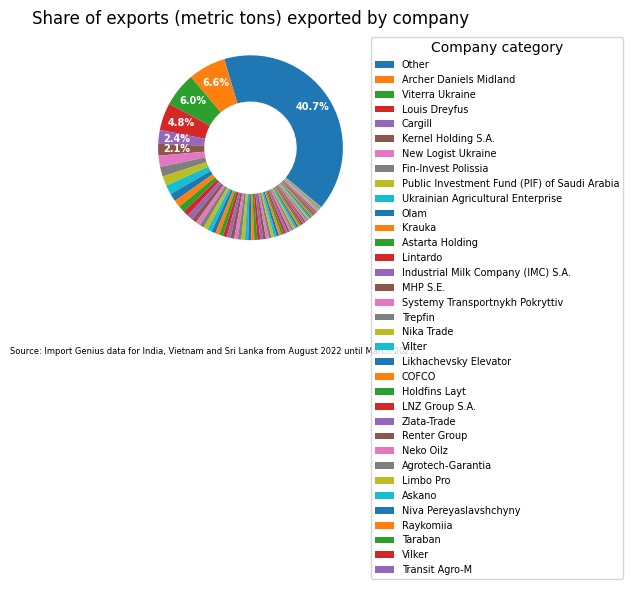

,company_std,weight_ton
0,Other,1893840.357
1,Archer Daniels Midland,305326.560
2,Viterra Ukraine,278390.438
3,Louis Dreyfus,223059.678
4,Cargill,111641.562
...,...,...
77,Agroton Public Limited,1597.730
78,Olyshchivka,1295.600
79,KSG Agro SA,841.568
80,Karla Marksa 2,566.795


In [6]:
# TODO: Use keyword arguments if it's not obvious what something is - 2, .5 for example
export_shares_all = plot_all_period(ig, "Import Genius data for India, Vietnam and Sri Lanka from August 2022 until March 2023", 2, 0.5)
export_shares_all

### MONTHLY STACKED BAR CHARTS

We convert the IG dataframe to a wide format so we can plot the monthly stacked bar charts.

In [11]:
# TODO: same note on keyword arguments
# Also, not totally clear what we are doing by passing different columns as arguments
pivot = create_wide_table(ig, ["year", "month", "company_std"], ["weight_ton"], ["year", "month", "company_std"], True, {"weight_ton": "sum"})
pivot

company_std,date,Agro-region,Agrofirm Svitanok,Agrofirma Rokytne,Agrotech-Garantia,Agroton Public Limited,Allseeds Group,Altpro,Amedia Group,Archer Daniels Midland,...,Ukrainian Agricultural Enterprise,Venom Grain,Vilker,Vilter,Viterra Ukraine,Vizmir Market,Vorozhbalatinvest LLC,Willers,Zerno Agro,Zlata-Trade
6,8/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,16871.7,NaN,NaN,NaN,NaN,NaN
7,9/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118599.7,...,NaN,NaN,NaN,NaN,90671.8,NaN,NaN,NaN,14386.0,NaN
1,10/2022,NaN,NaN,NaN,6594.8,NaN,4423.5,13466.9,NaN,66659.2,...,NaN,NaN,NaN,NaN,29542.6,NaN,6805.1,NaN,NaN,NaN
2,11/2022,NaN,18097.2,NaN,7151.0,1597.7,NaN,NaN,NaN,58132.5,...,NaN,NaN,NaN,NaN,53295.9,NaN,NaN,NaN,NaN,NaN
3,12/2022,10514.6,126.7,NaN,3444.6,NaN,NaN,NaN,NaN,44056.1,...,NaN,19890.3,11098.1,21979.8,46688.3,5291.8,NaN,NaN,NaN,NaN
0,1/2023,1292.4,NaN,NaN,NaN,NaN,NaN,NaN,16653.3,NaN,...,32700.0,NaN,12497.0,13325.0,NaN,8689.0,NaN,NaN,NaN,NaN
4,2/2023,6938.4,NaN,22822.9,419.6,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,14248.0,2683.4,NaN,NaN,NaN,16772.8
5,3/2023,905.9,3035.7,NaN,11686.7,NaN,NaN,NaN,NaN,17879.1,...,43906.5,NaN,NaN,NaN,27072.1,1563.8,NaN,13076.0,NaN,13299.3


Now we do the same but we estimate the percentages of the wide table

In [12]:
percentages = pivot.copy()
percentages_df = estimate_table_percentages(percentages)
percentages_df

company_std,Agro-region,Agrofirm Svitanok,Agrofirma Rokytne,Agrotech-Garantia,Agroton Public Limited,Allseeds Group,Altpro,Amedia Group,Archer Daniels Midland,Ardeon Tsentr,...,Venom Grain,Vilker,Vilter,Viterra Ukraine,Vizmir Market,Vorozhbalatinvest LLC,Willers,Zerno Agro,Zlata-Trade,date
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,58.93,0.00,0.00,0.00,0.00,0.00,8/2022
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,13.88,0.00,...,0.00,0.00,0.00,10.61,0.00,0.00,0.00,1.68,0.00,9/2022
1,0.00,0.00,0.00,1.03,0.00,0.69,2.11,0.00,10.46,0.00,...,0.00,0.00,0.00,4.64,0.00,1.07,0.00,0.00,0.00,10/2022
2,0.00,3.24,0.00,1.28,0.29,0.00,0.00,0.00,10.41,0.00,...,0.00,0.00,0.00,9.55,0.00,0.00,0.00,0.00,0.00,11/2022
3,1.21,0.01,0.00,0.40,0.00,0.00,0.00,0.00,5.07,0.31,...,2.29,1.28,2.53,5.37,0.61,0.00,0.00,0.00,0.00,12/2022
0,0.26,0.00,0.00,0.00,0.00,0.00,0.00,3.36,0.00,0.00,...,0.00,2.52,2.69,0.00,1.75,0.00,0.00,0.00,0.00,1/2023
4,1.32,0.00,4.33,0.08,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,2.70,0.51,0.00,0.00,0.00,3.18,2/2023
5,0.13,0.44,0.00,1.71,0.00,0.00,0.00,0.00,2.62,0.00,...,0.00,0.00,0.00,3.96,0.23,0.00,1.91,0.00,1.95,3/2023


Now we plot the stacked bar with our wide format table we created earlier.

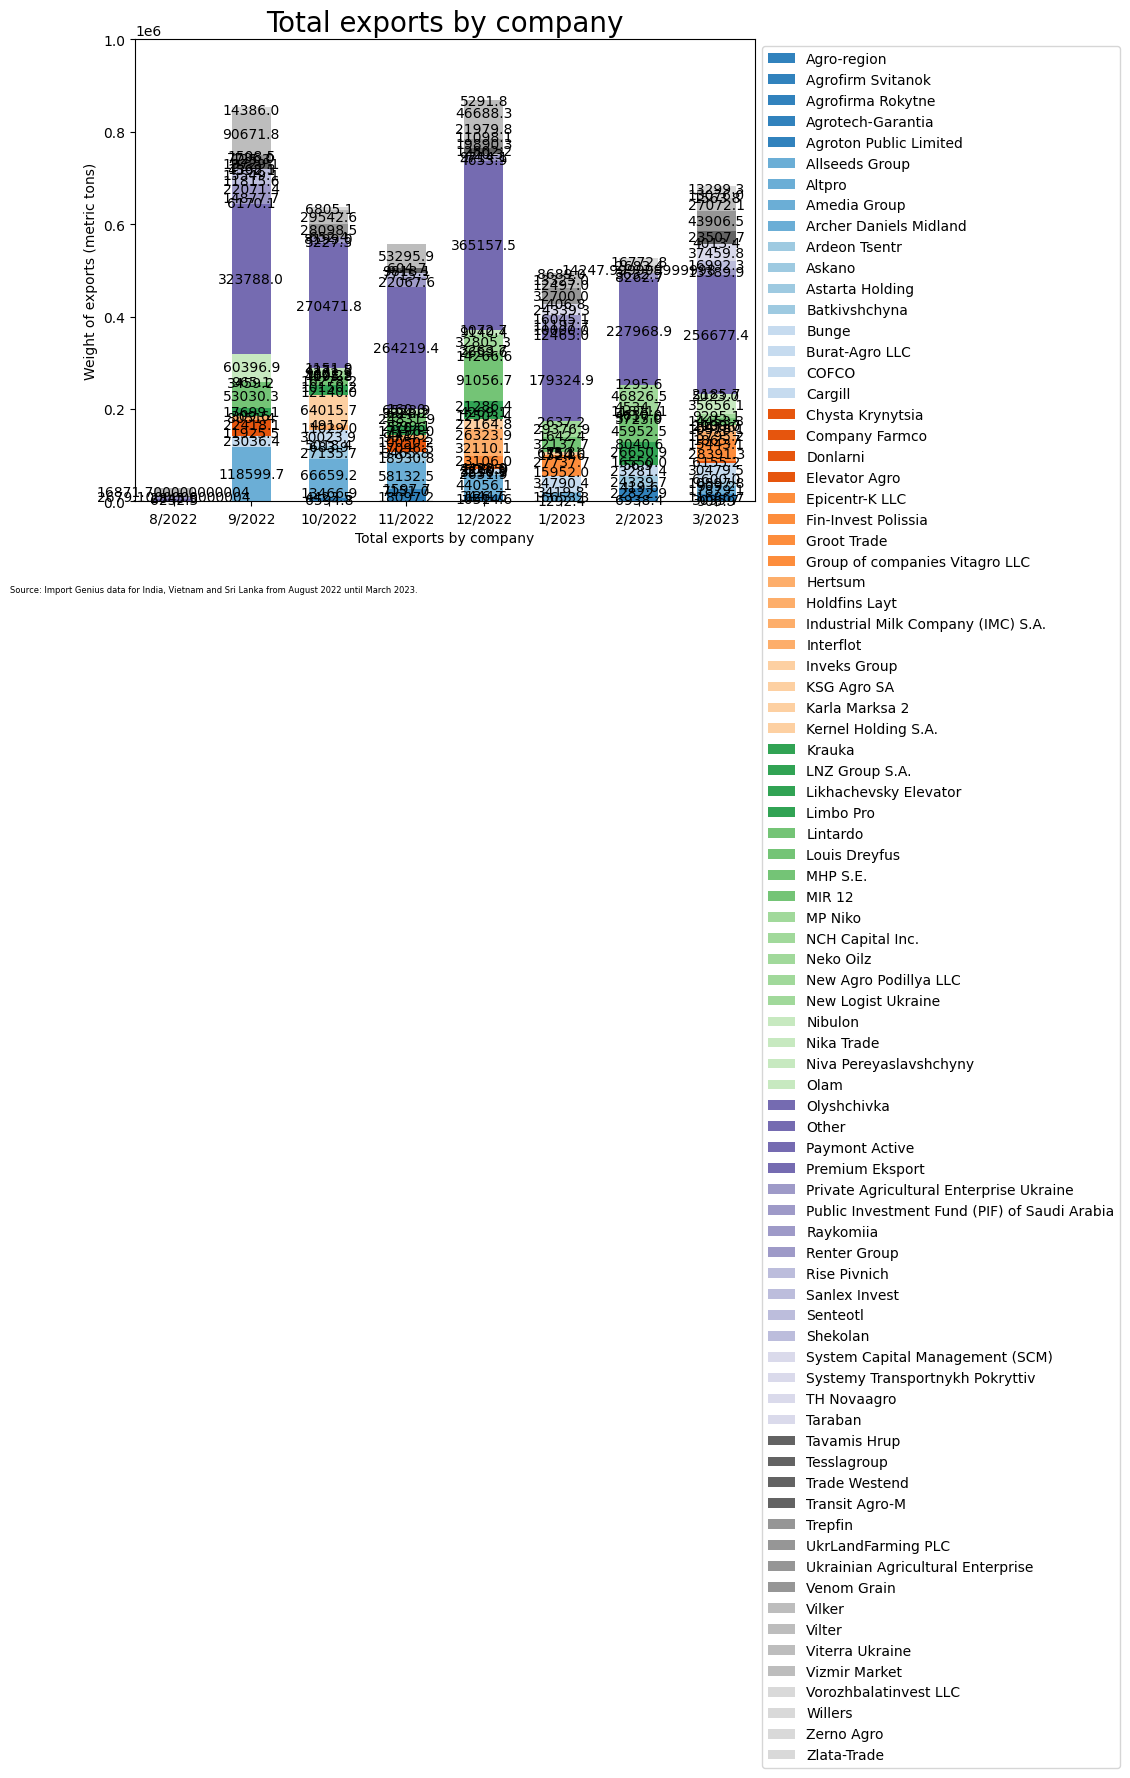

In [14]:
plot_stack_bar(pivot, "Total exports by company", "Weight of exports (metric tons)", "Total exports by company", "date", 1000000, "Import Genius data for India, Vietnam and Sri Lanka from August 2022 until March 2023")

Now we do the same but with percentages

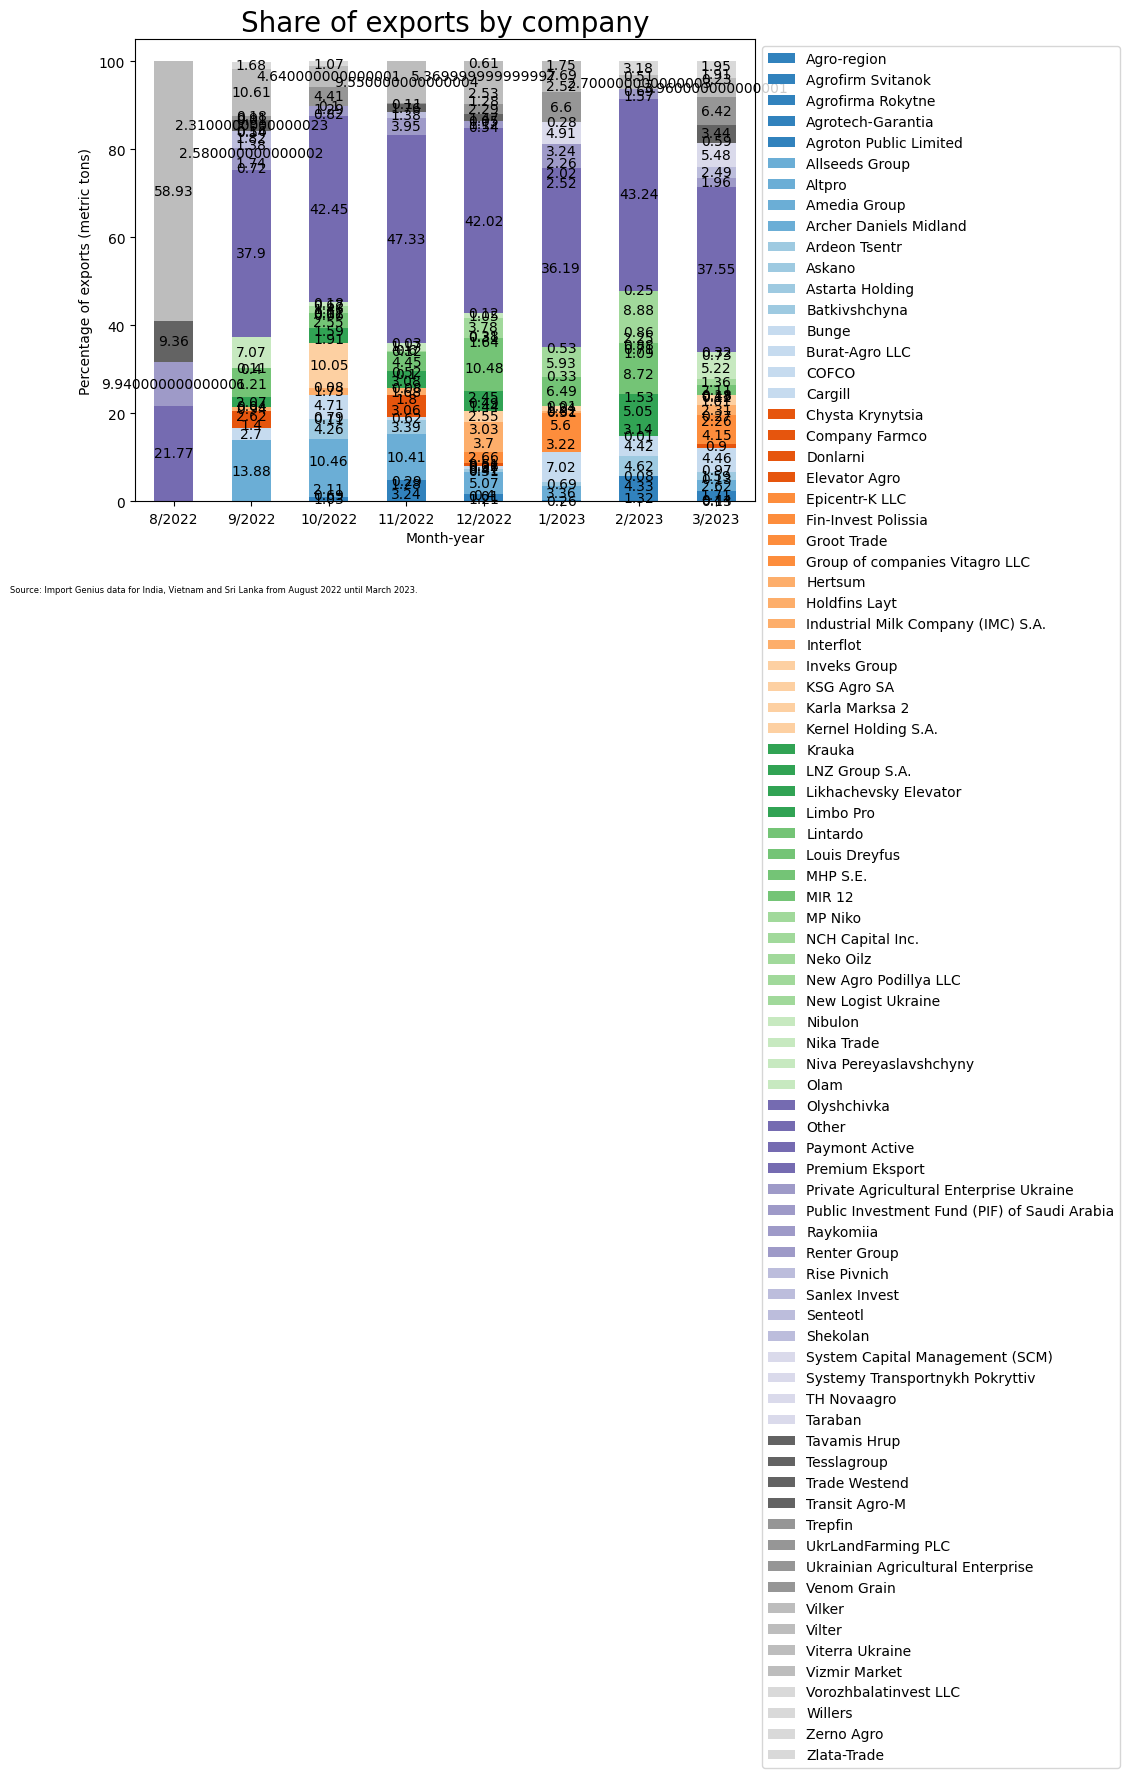

In [15]:
plot_stack_bar(percentages_df, "Month-year", "Percentage of exports (metric tons)", "Share of exports by company", "date", 105, "Import Genius data for India, Vietnam and Sri Lanka from August 2022 until March 2023")

## TABLE WITH EXPORTS BY COMPANY (ALL COMPANIES INCLUDED)

Now we get the whole table with all companies exporting to Ukraine to export it and share it with Oakland Institute (OI).

In [17]:
ig["company_all"] = ig["company_std"]
for idx, row in ig.iterrows():
    if row["company_std"] == "Other":
        ig["company_all"][idx] = ig["shipper"][idx]

/var/folders/fp/_kmrwvmj0790xd_yv16gm1t80000gn/T/ipykernel_60910/3077394398.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ig["company_all"][idx] = ig["shipper"][idx]


We create a new column with the company names translated from Ukrainian to English.

In [18]:
ig_all_comp = cargo_grouping(ig, ["company_all"], ["weight_ton"], ["weight_ton"], True, {"weight_ton": "sum"})
ig_all_comp = ig_all_comp.sort_values(by=["weight_ton"], ascending=[False])
translate_column(ig_all_comp, "company_all", "google", source="uk", target="en") # this step takes awhile

We export the table as a .csv file.

In [19]:
ig_all_comp.to_csv('../data/total_exports_by_company_spain.csv', index=False)
ig_all_comp.head()

,company_all,weight_ton,company_all_gt
8,Archer Daniels Midland,305326.560,Archer Daniels Midland
76,Viterra Ukraine,278390.438,Viterra Ukraine
38,Louis Dreyfus,223059.678,Louis Dreyfus
16,Cargill,111641.562,Cargill
32,Kernel Holding S.A.,95709.952,Kernel Holding S.A.


## EXPLORATORY ANALYSIS FOR MANUAL COMPANY MATCHING

We first get the top n companies exporting to Ukraine.

In [20]:
tempo = cargo_grouping(ig, ["company_all"], ["weight_ton"], ["weight_ton"], True, {"weight_ton": "sum"})
tempo.sort_values(by=["weight_ton"], ascending=False)[50:70]

,company_all,weight_ton
23,Groot Trade,15443.137
80,Zerno Agro,14385.995
67,Tesslagroup,13951.770
6,Altpro,13466.896
79,Willers,13075.962
68,Trade Westend,12802.244
51,Paymont Active,12465.000
60,Shekolan,12307.400
19,Donlarni,11925.453
41,MP Nіko,11871.110


Then we get the full company name.

In [21]:
tempo.loc[698]["company_all"]

'ТОВ ПРОМІНЬ ПОДІЛЛЯ УКРАЇНА 32625 ХМЕЛЬНИЦЬКА ОБЛ КАМ ЯНЕЦЬ ПОДІЛЬСЬКИЙ Р Н С ПЕСЕЦЬ'

We double check that the company is actually exporting crops to confirm we filtered the IG dataset correctly with companies that only export agricultural products that appear in BSGI.

In [22]:
ig[ig["shipper"] == 'ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ МП НІКО УКРАЇНА 01133 МІСТО КИЇВ БУЛЬВАР ЛЕСІ УКРАЇНКИ БУДИНОК 28 КВАРТИР']["product"]

1447    пшениця і суміш пшениці та жита (меслин): - ін...
Name: product, dtype: object

We check if there are any name matches with the Land Matrix company parents we found
in Land Matrix.

First we get the Land Matrix data.

In [23]:
deals = pd.read_csv("../data/land_matrix/deals.csv", delimiter=";")
deals_c = deals.copy()
deals_c.loc[:, "country_low"] = deals_c.loc[:, "Target country"].str.lower()
deals_c = deals_c.loc[deals_c.loc[:, "country_low"].str.contains("ukraine", na=False)]
deals_c["Target country"]

/var/folders/fp/_kmrwvmj0790xd_yv16gm1t80000gn/T/ipykernel_60910/99570549.py:1: DtypeWarning: Columns (139) have mixed types. Specify dtype option on import or set low_memory=False.
  deals = pd.read_csv("../data/land_matrix/deals.csv", delimiter=";")


572     Ukraine
573     Ukraine
574     Ukraine
575     Ukraine
576     Ukraine
         ...   
6461    Ukraine
6462    Ukraine
6463    Ukraine
6464    Ukraine
6467    Ukraine
Name: Target country, Length: 358, dtype: object

In [24]:
deals_c[deals_c["Top parent companies"].str.lower().str.contains("premium")]["Top parent companies"]

Series([], Name: Top parent companies, dtype: object)

In [25]:
sorted(deals_c["Top parent companies"].unique())

['AGR Invest Holding Ltd#40757#',
 'AGT Capital Management Ltd.#41248#',
 'Agro Ukraina AB#44407#',
 'Agro-Podillya i K LLC#43419#',
 'AgroGeneration#656#',
 'AgroGeneration#656#|Azent Ltd.#40783#',
 'AgroGeneration#656#|L`ost Dominic#41121#|Mandua Catrin#41123#|Claud Mandua#41124#',
 'Agromino A/S#4970#',
 'Agroton Public Limited#38647#',
 'Agrovista Limited#41491#',
 'Akella Impex LP#5042#',
 'Aladin tekstil ve hiyim iuriunleri tidzharet LLC#44904#',
 'Alberto Kazoni#5062#|Kyrylenko Volodymyr#5063#|Vorotyntsev Vitaliy#5064#',
 'Albus Gunter#41907#',
 'Alexander Wolters#41898#',
 'Alpha-Capital LLC#44409#',
 'Aslan Global Management#1779#',
 'BKW Group LLC#43027#',
 'Berend Popke van der Velde#40762#|Herrit Tonkens#40763#|Huzinha Kornelius Hendrick#40764#|Oxana Kryachko#40765#',
 'Berry Farma ApS#5060#',
 'Bitex Trade Ltd.#43046#',
 'Bontrup Holding#4963#',
 'Brunner&Partner LLC#5047#|Glendore Holding LLC#5048#',
 "Brykivs'ke LLC#43422#",
 'CNBM International energy PTE.LTD#44677#',
 

## DIFFERENCE IN EXPORTS BETWEEN IG AND BSGI

We do some analysis to see why we have differences in weights between IG and BSGI

In [26]:
ig_g = cargo_grouping(ig, ["year", "month"], ["weight_ton"], ["year", "month"], True, {"weight_ton": "sum"}).rename(columns={"weight_ton": "IG"})
ig_g["date"] = ig_g["month"].astype(str) + "/" + ig_g["year"].astype(str)
ig_g = ig_g.drop(['year', 'month'], axis=1)
ig_g = ig_g[["date", "IG"]]

bsgi_g = cargo_grouping(bsgi, ["year", "month"], ["weight_ton"], ["year", "month"], True, {"weight_ton": "sum"}).rename(columns={"weight_ton": "BSGI"})
bsgi_g["date"] = bsgi_g["month"].astype(str) + "/" + bsgi_g["year"].astype(str)
bsgi_g = bsgi_g.drop(['year', 'month'], axis=1)
bsgi_g = bsgi_g[["date", "BSGI"]]

final = ig_g.merge(bsgi_g, on="date", suffixes=("_ig", "_bsgi")).round(1)
final

,date,IG,BSGI
0,8/2022,28628.7,151215
1,9/2022,854280.0,969183
2,10/2022,637181.3,677244
3,11/2022,558257.0,447753
4,12/2022,868976.7,656332
5,1/2023,495452.5,466657
6,2/2023,527222.1,516507
7,3/2023,683573.2,636927


Text(-90, -60, 'Source: IG and BSGI exports to India, Vietnam and Sri Lanka from August 2022 until March 2023.')

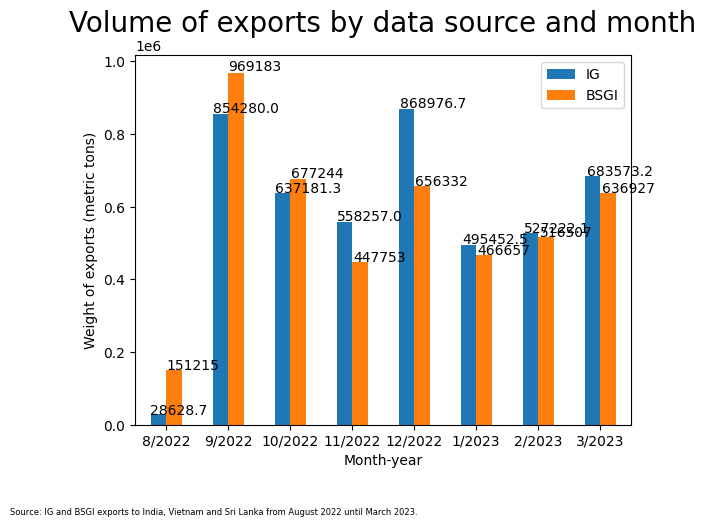

In [27]:
ax = final.plot.bar(rot=0)
ax.set_title("Volume of exports by data source and month", fontsize=20)
ax.set_xticklabels(final["date"], rotation=0)
ax.set_xlabel("Month-year")
ax.set_ylabel("Weight of exports (metric tons)")
for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
ax.annotate(f"Source: IG and BSGI exports to India, Vietnam and Sri Lanka from August 2022 until March 2023.", (0,0), (-90,-60), fontsize=6, 
             xycoords='axes fraction', textcoords='offset points', va='top')